In [590]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as scipy
from scipy.optimize import minimize
from copy import deepcopy as deepcopy
from scipy.integrate import odeint
import torch

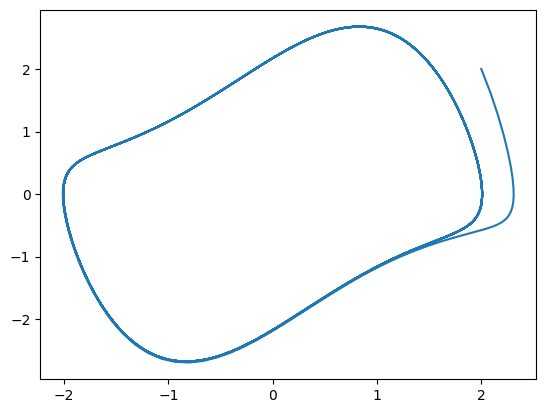

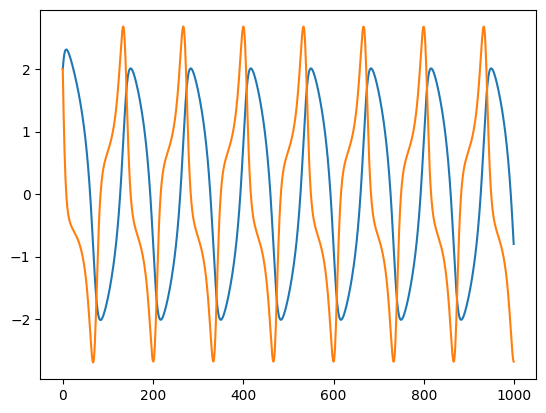

In [617]:
mu = 1

def van_der_pol_oscillator_deriv(x, t):
    nx0 = x[1]
    nx1 = mu * ( 1.0 - x[0] ** 2.0 ) * x[1] - x[0]
    res = np.array([nx0, nx1])
    return res

ts = np.linspace(0.0, 50.0, 1000)

xs = odeint(van_der_pol_oscillator_deriv, [2, 2], ts)
plt.plot(xs[:,0], xs[:,1])
plt.savefig('vanderpol_oscillator.png')
plt.show() 

data_1 = np.asarray([xs[:,0],xs[:,1]])

plt.plot(data_1.T)


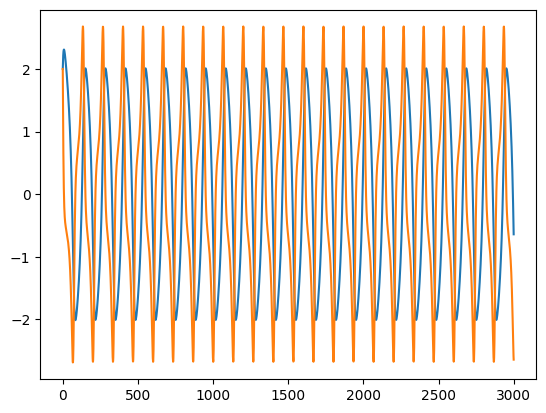

In [618]:
#metodo de euler

def van_der_pol(x, y, mu=1):

    x_dot = y
    y_dot = mu * ( 1.0 - x ** 2.0 ) * y - x

    return x_dot, y_dot

dt = 0.001
num_steps = 150000

# Need one more for the initial values
xs = np.empty(num_steps + 1)
ys = np.empty(num_steps + 1)

# Set initial values
xs[0], ys[0] = (2,2)

# Step through "time", calculating the partial derivatives at the current point
# and using them to estimate the next point
for i in range(num_steps):
    x_dot, y_dot = van_der_pol(xs[i], ys[i])
    xs[i + 1] = xs[i] + (x_dot * dt)
    ys[i + 1] = ys[i] + (y_dot * dt)

data = np.asarray([xs,ys])

data = data[:,::50]
plt.plot(data.T)



In [619]:
class ESN:

    def __init__(self, tam_input, tam_output, tam_reservatorio,u,data,tam_treino,tam_test,tam_teacher_force,warm_up):

        self.tam_input = tam_input
        self.tam_output = tam_output
        self.tam_reservatorio = tam_reservatorio

        self.data = data
        self.tam_treino = tam_treino
        self.tam_test = tam_test
        self.tam_teacher_force = tam_teacher_force
        self.warm_up = warm_up
        self.u = u

        self.W = None
        self.Win = None
        self.Wf = None
        self.Wout = None
        
        self.data_treino = None
        self.data_test = None
        self.noise = None
        self.xs = None
        self.ys = None
        self.zs = None
        self.xs_n = None
        self.ys_n = None
        self.zs_n = None
        self.data_n = None
        self.y_last_result = None
        self.x_test = None

        self.last_state = None
        self.result = None
        self.X_otimizador = None

    def split_data(self,noise_value):
        
        xs = self.data[0,:]
        ys = self.data[1,:]
        self.xs = xs
        self.ys = ys

        data_norm_1 = xs
        data_norm_2 = ys

        self.xs_n = data_norm_1
        self.ys_n = data_norm_2

        data_n = np.asarray([data_norm_1,data_norm_2])

        self.data_n = data_n

        self.data_treino = data_n[:,:self.tam_treino]

        self.data_test = data_n[:,self.tam_treino:self.tam_treino+self.tam_teacher_force]

        self.noise = np.random.uniform(-noise_value, noise_value, self.data_treino.shape)

        self.Yt = data_n[:, self.warm_up + 1: self.tam_treino + 1] 


    def gerar_pesos(self, value_spectral_r):
        
        W =  np.random.uniform(-1,1,[self.tam_reservatorio,self.tam_reservatorio])

        eigenvalues , eigenvectors = np.linalg.eig(W)
        spectral_r = np.max(np.abs(eigenvalues))

        self.W = W * value_spectral_r/spectral_r

        self.Win = np.random.choice([0,-0.15,0.15], [self.tam_reservatorio,self.tam_input], p=[0.5, 0.25, 0.25])

        self.Wf = np.random.uniform(-0.15,0.15,[self.tam_reservatorio,self.tam_output])
    
    def treino(self, reg):

        a = 1
        C = 1 # global constant

        X = np.zeros((self.tam_reservatorio,self.tam_treino))

        x = np.zeros((self.tam_reservatorio,1))

        for t in range(self.tam_treino):

            data_feedback = self.data_treino[:,t]
            data_feedback = np.reshape(data_feedback,(self.tam_output,1))

            x = (1-C*a)*x + C*np.tanh( np.dot(self.Win, self.u)  + np.dot(self.W, x) + np.dot(self.Wf, data_feedback))
            X[:,t] = np.vstack(x)[:,0]

        X = X[:,self.warm_up:]

        self.X_otimizador = X

        self.Wout = np.dot( np.dot(self.Yt, (X.T)), np.linalg.inv(np.dot(X,(X.T)) +  reg*np.eye(self.tam_reservatorio)))

        self.last_state = x

    def test(self,Wout):

        a = 1
        C = 1 # global constant

        Y = np.zeros((self.tam_output,self.tam_test+self.tam_teacher_force))

        x = self.last_state

        y = self.X_otimizador.T@self.Wout.T
        y = y[-1,:]

        for t in range(self.tam_teacher_force):

            data_feedback = self.data_test[:,t]
            data_feedback = np.reshape(data_feedback,(self.tam_output,1))
            x = (1-C*a)*x + C*np.tanh( np.dot(self.Win, self.u)  + np.dot(self.W, x) + np.dot(self.Wf, data_feedback))
            y = np.dot(Wout, x)
            y = np.reshape(y,(self.tam_output))
            Y[:,t] = y

        self.x_test = np.zeros((self.tam_reservatorio,self.tam_test)) 

        for t in range(self.tam_test):

            y = np.reshape(y,(self.tam_output,1))
            x = (1-C*a)*x + C*np.tanh( np.dot(self.Win, self.u)  + np.dot(self.W, x) + np.dot(self.Wf, y))
            y = np.dot(Wout, x)
            y = np.reshape(y,(self.tam_output))
            self.x_test[:,t] = np.reshape(x,(self.tam_reservatorio))
            Y[:,t+self.tam_teacher_force] = y
        
        self.result = Y


In [681]:
#dados rede
np.random.seed(44)
tam_treino = 90
tam_teste = 2000
tam_teste_teacher = 0
warm_up = 0
tam_input = 2
tam_output = 2
tam_reservatorio = 50
noise_value = 0
spectral_r = 0.4
reg = 1e-5
u = np.asarray([0,0])
u = np.reshape(u,(2,1))


In [682]:
test = ESN(tam_input,tam_output,tam_reservatorio,u,data,tam_treino,tam_teste,tam_teste_teacher,warm_up)
test.split_data(noise_value)
test.gerar_pesos(spectral_r)
test.treino(reg)
test.test(test.Wout)



In [596]:
np.shape(test.X_otimizador)

(50, 90)

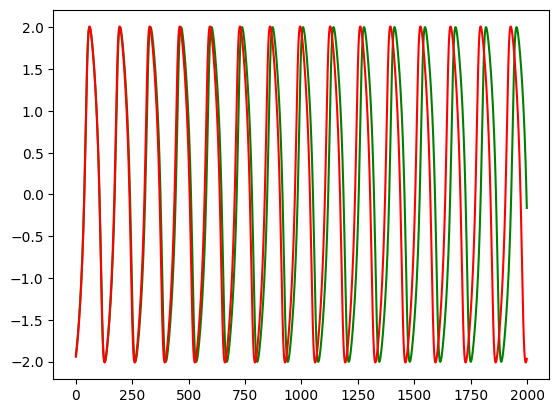

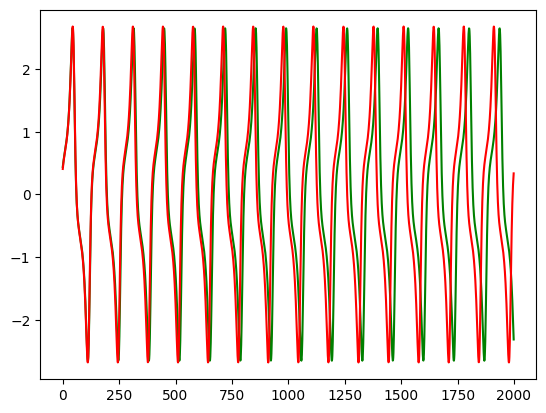

In [597]:
corte_dados = test.tam_treino+test.tam_teacher_force

previsao_x = deepcopy(test.result.T[test.tam_teacher_force:test.tam_teacher_force+tam_teste,0])
resultado_x = test.data_n.T[corte_dados:corte_dados+tam_teste,0]

previsao_y = deepcopy(test.result.T[test.tam_teacher_force:test.tam_teacher_force+tam_teste,1])
resultado_y = test.data_n.T[corte_dados:corte_dados+tam_teste,1]

plot1 = plt. figure(1)
plt. plot(previsao_x,'g')
plt. plot(resultado_x,'r')
plot2 = plt. figure(2)
plt. plot(previsao_y,'g')
plt. plot(resultado_y,'r')



In [575]:
teste_o = deepcopy(test)


In [576]:
#Wout_torch = torch.tensor(np.random.uniform(-1,1,[test.tam_reservatorio,test.tam_output]), requires_grad=True)
Wout_torch = torch.tensor(teste_o.Wout.T, requires_grad=True)
x_test = torch.tensor(teste_o.x_test, requires_grad=True)
optimizer = torch.optim.Adam([Wout_torch],lr = 1e-5)


In [577]:
lista_dados  = [] 
lista_fisica = []
lista_MSE = []

for j in range(1000):
    
    x_test = torch.tensor(teste_o.x_test, requires_grad=False)

    for i in range(1000):

        optimizer.zero_grad()
        x_test = torch.tensor(teste_o.x_test, requires_grad=False)

        y = Wout_torch.T @ x_test
        dt = 0.001*50

        n_amostras = tam_treino*tam_input
        yt = torch.tensor(teste_o.Yt.T, requires_grad=False)
        X = torch.tensor(teste_o.X_otimizador.T, requires_grad=False)

        custo_dados = (1/(2*n_amostras))*torch.sum((X@Wout_torch - yt)**2)

        x = y[0,:999]
        y1 = y[1,:999]

        nx = y[0,1:1000]
        ny = y[1,1:1000]

        custo_fisica_1 =  (y1*dt - nx + x)**2
        custo_fisica_2 =  ( (-mu*(x**2 - 1)*y1 - x)*dt + y1 - ny )**2

        custo_fisica = torch.sum(custo_fisica_1 + custo_fisica_2)/(2*1000)

        custo_total_t = 1e-2*custo_fisica + custo_dados

        custo_total_t.backward()

        optimizer.step()
    
        theta = Wout_torch.detach().numpy()

        lista_dados.append(custo_dados.detach().numpy())
        lista_fisica.append(custo_fisica.detach().numpy())
        erro = ( np.sum( (resultado_x - (theta.T@teste_o.x_test).T[:,0] ) **2 ) + np.sum( ( (resultado_y - (theta.T@teste_o.x_test).T[:,1])**2 )) )/4000
        lista_MSE.append(  erro)
    print(erro, (np.sum((resultado_x - previsao_x)**2) + np.sum((resultado_y - previsao_y)**2))/4000)
    teste_o.test(theta.T)

    


1.1892144114854082 1.189235142804124
1.1399326352214667 1.189235142804124
1.0861329979714864 1.189235142804124
1.0393003775035372 1.189235142804124
0.9942606075932834 1.189235142804124
0.9536635722904109 1.189235142804124
0.922020848250417 1.189235142804124
0.8845991243154822 1.189235142804124
0.8741759131521082 1.189235142804124
0.8579128290481915 1.189235142804124
0.8397991305344712 1.189235142804124
0.8272544588341325 1.189235142804124
0.8108795587901282 1.189235142804124
0.8050119476629655 1.189235142804124
0.7935915569013684 1.189235142804124
0.7822916969891885 1.189235142804124
0.7814227002726967 1.189235142804124
0.7765375082947454 1.189235142804124
0.7677790384883153 1.189235142804124
0.758797548829516 1.189235142804124
0.7549165921550381 1.189235142804124
0.7504637166290262 1.189235142804124
0.7445713765716155 1.189235142804124
0.7373654299579497 1.189235142804124
0.735347043305253 1.189235142804124
0.7307020115957025 1.189235142804124
0.7260703609490249 1.189235142804124
0.72

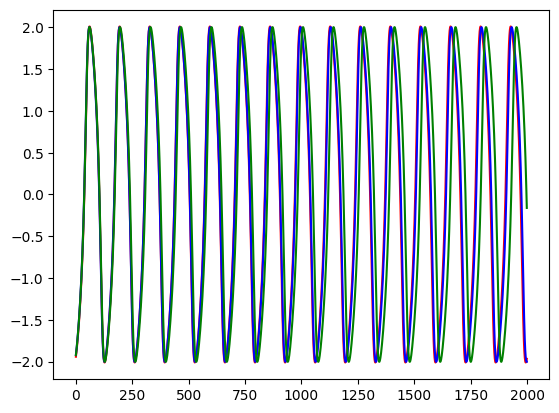

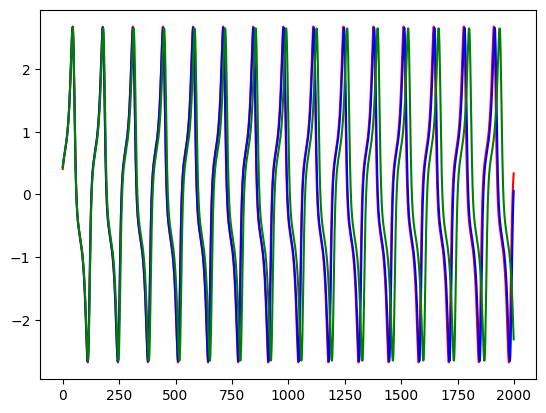

In [579]:
theta = Wout_torch.detach().numpy()
test.test(theta.T)
plot1 = plt. figure(1)
plt. plot(resultado_x,'r')
plt.plot((theta.T@teste_o.x_test).T[:,0],'b')
plt. plot(previsao_x,'g')
plot2 = plt. figure(2)
plt. plot(resultado_y,'r')
plt.plot((theta.T@teste_o.x_test).T[:,1],'b')
plt. plot(previsao_y,'g')


In [339]:
lista_MSE[-2000]

17.549600701771176

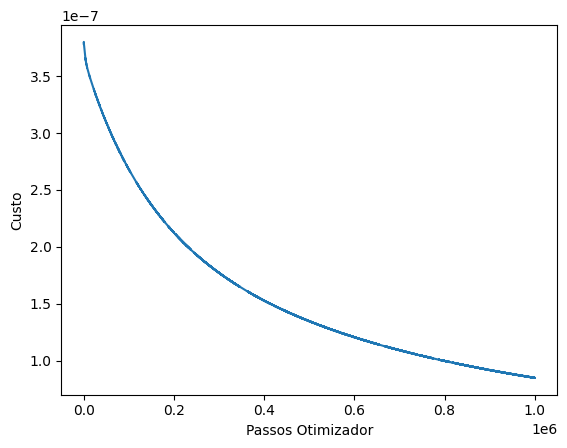

In [585]:

plot1 = plt. figure(1)
plt.plot(lista_dados)
plt.ylabel("Custo")
plt.xlabel("Passos Otimizador")
plt.savefig('funcao_custo_dados_1.jpg', format='jpg')


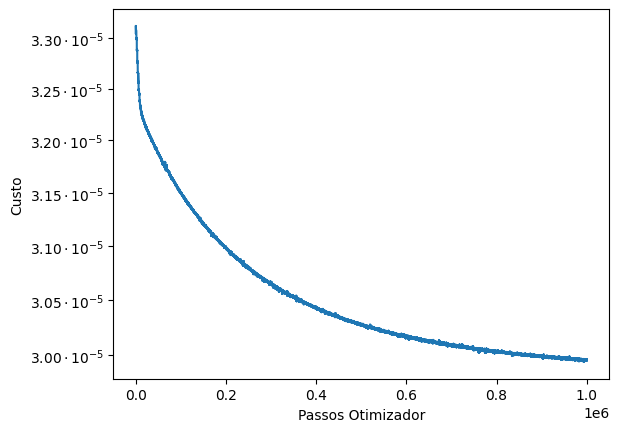

In [581]:
plot1 = plt. figure(1)
plt.plot(lista_fisica)
plt.ylabel("Custo")
plt.xlabel("Passos Otimizador")
plt.yscale('logit') 
plt.savefig('funcao_custo_fisica_1.jpg', format='jpg',dpi = 150)

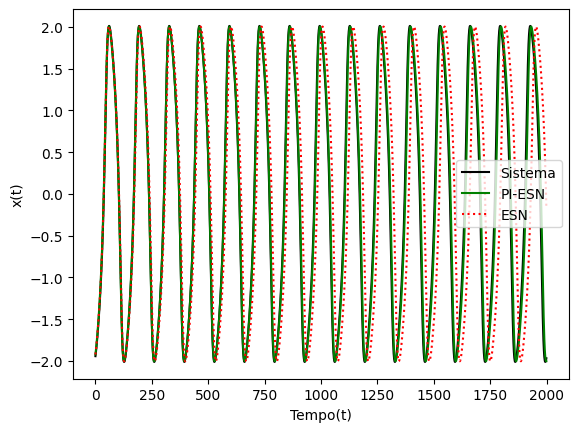

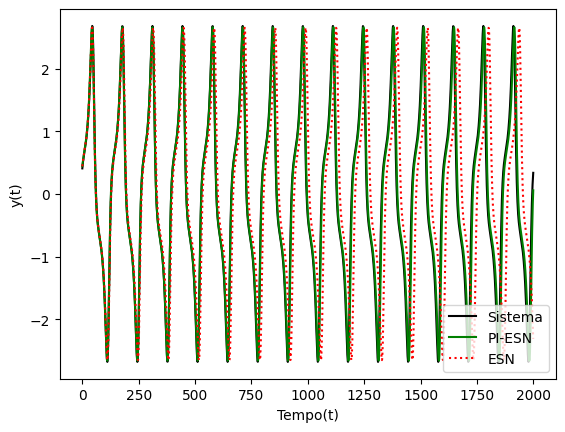

In [602]:
theta = Wout_torch.detach().numpy()

test.test(theta.T)
plot1 = plt. figure(1)
plt. plot(resultado_x,'black')
plt.plot((theta.T@test.x_test).T[:,0],'g')
plt. plot(previsao_x,'r', linestyle = "dotted")
plt.legend(["Sistema","PI-ESN","ESN"]) 
plt.ylabel("x(t)")
plt.xlabel("Tempo(t)")
plt.savefig('x.jpg', format='jpg')

plot2 = plt. figure(2)
plt. plot(resultado_y,'black')
plt.plot((theta.T@test.x_test).T[:,1],'g')
plt. plot(previsao_y,'r', linestyle = "dotted")
plt.legend(["Sistema","PI-ESN","ESN"]) 
plt.ylabel("y(t)")
plt.xlabel("Tempo(t)")
plt.savefig('y.jpg', format='jpg')


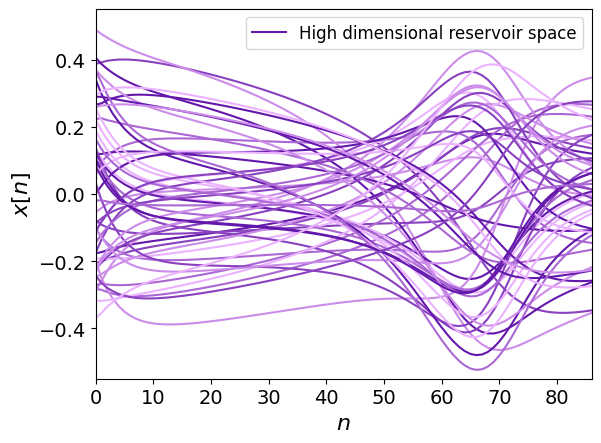

In [701]:
palette1 = ['#6418ab','#8941bf','#ab67d4','#cc8ce9','#ebb2ff']


# Crie os numpy arrays com o shape (2000, 50)
array1 = test.X_otimizador.T[3:,:] # Substitua isso pelo seu primeiro array

for i in range(50):
    color1 = palette1[i % len(palette1)]
    plt.plot(array1[:,i], color=color1)

plt.legend(['High dimensional reservoir space'], ncol = 1, fontsize='large', loc='upper right')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0,86)
plt.ylim(-0.55,0.55)
# Adicione legendas
plt.ylabel('$x[n]$', fontsize=16)
plt.xlabel('$n$', fontsize=16)
plt.savefig('X.jpg', format='jpg', dpi=900, bbox_inches='tight')


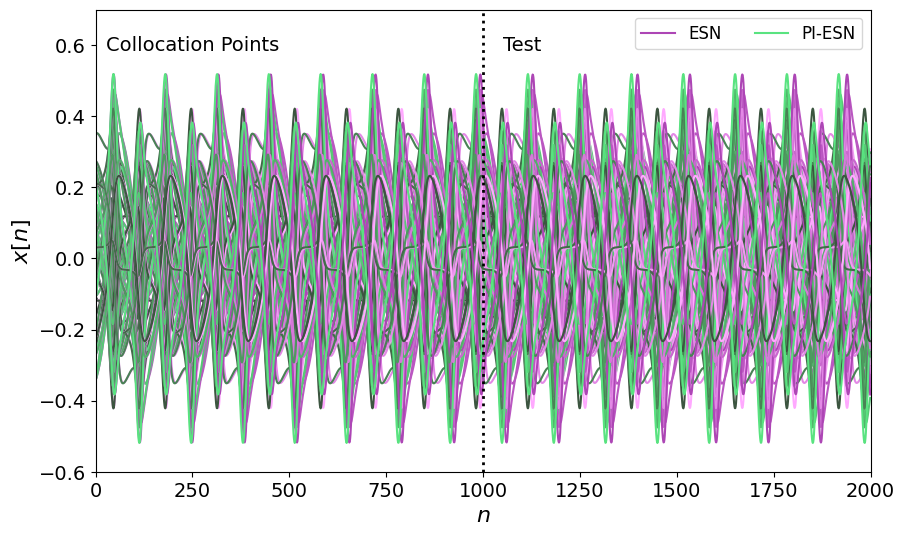

In [700]:
# Crie os numpy arrays com o shape (2000, 50)
array1 = test.x_test.T # Substitua isso pelo seu primeiro array
array2 = teste_o.x_test.T  # Substitua isso pelo seu segundo array

# Defina as paletas de cores
palette2 = ['#59e380', '#56ca75', '#53b16a','#4e995f','#498255','#436b4a','#3c5540']
palette1 = ['#ad46b5','#ba57c1','#c868cd','#d678da','#e388e6','#f199f2','#ffa9ff']

# Crie uma figura
plt.figure(figsize=(10, 6))

# Plote as linhas usando cores aleatórias para cada ponto nos arrays
for i in range(50):
    color1 = palette1[i % len(palette1)]
    color2 = palette2[i % len(palette1)]
    plt.plot(array1[:,i], color=color1)
    plt.plot(array2[:,i], color=color2)

plt.axvline(1000, linewidth=2, color='black',linestyle = 'dotted')
plt.annotate('Collocation Points', xy = (250,0.6), va = 'center', ha = 'center', fontsize = 14)
plt.annotate('Test', xy = (1100, 0.6), va = 'center', ha = 'center', fontsize = 14)

plt.legend(['ESN', 'PI-ESN'], ncol =2, fontsize='large', loc='upper right')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0,2000)
plt.ylim(-0.6,0.7)
# Adicione legendas
plt.ylabel('$x[n]$', fontsize=16)
plt.xlabel('$n$', fontsize=16)
# Exiba o gráfico de linha

plt.savefig('states.jpg', format='jpg', dpi=900, bbox_inches='tight')
plt.show()

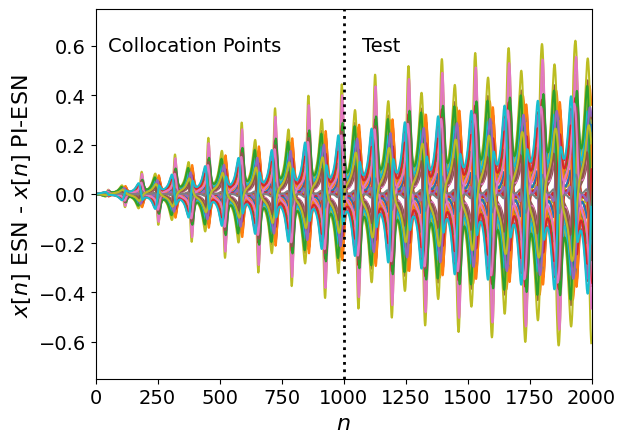

In [758]:
# Crie os numpy arrays com o shape (2000, 50)
array1 = test.x_test.T # Substitua isso pelo seu primeiro array
array2 = teste_o.x_test.T  # Substitua isso pelo seu segundo array


plt.plot((array1 - array2))


plt.axvline(1000, linewidth=2, color='black',linestyle = 'dotted')
plt.annotate('Collocation Points', xy = (400,0.6), va = 'center', ha = 'center', fontsize = 14)
plt.annotate('Test', xy = (1150, 0.6), va = 'center', ha = 'center', fontsize = 14)

#plt.legend([], ncol =2, fontsize='large', loc='lower right')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0,2000)
plt.ylim(-0.75,0.75)
# Adicione legendas
plt.ylabel('$x[n]$ ESN - $x[n]$ PI-ESN ', fontsize=16)
plt.xlabel('$n$', fontsize=16)
# Exiba o gráfico de linha

plt.savefig('states.jpg', format='jpg', dpi=900, bbox_inches='tight')
plt.show()

In [ ]:

# Defina as paletas de cores
palette2 = ['#59e380']
palette1 = ['#ad46b5']

# Defina as paletas de cores
#palette2 = ['#59e380', '#56ca75', '#53b16a','#4e995f','#498255','#436b4a','#3c5540']
#palette1 = ['#ad46b5','#ba57c1','#c868cd','#d678da','#e388e6','#f199f2','#ffa9ff']

plt.plot(test.Wout.T, '.', label = 'ESN',color ='#ad46b5')
plt.plot(theta, '.', label = 'PI-ESN', color = '#59e380')  
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Numerical Value',fontsize=16)
plt.xlabel('$W^{out}$', fontsize=16)
plt.legend(['ESN','PI-ESN'], fontsize='large', loc='upper right')
plt.savefig('Woutchange.jpg', format='jpg', dpi=900, bbox_inches='tight')
plt.show()

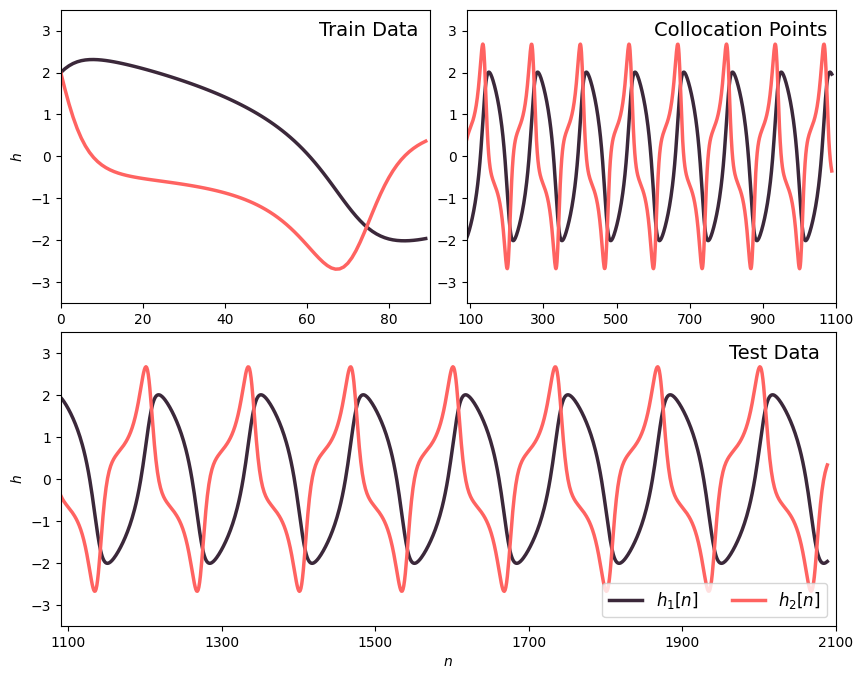

In [772]:
fig = plt.figure(figsize=(10, 8))
linewidth_tam = 2.5

plt.subplots_adjust(wspace= 0.1, hspace= 0.1)

sub1 = fig.add_subplot(2,2,1) # two rows, two columns, fist cell
plt.annotate('Train Data', xy = (75, 3), va = 'center', ha = 'center', fontsize = 14)
#plt.annotate('Validation \n Data', xy = (1970, 3), va = 'center', ha = 'center', fontsize = 14)
sub1.plot(data.T[:tam_treino,0],color ='#3b283a', linewidth= linewidth_tam)
sub1.plot(data.T[:tam_treino,1],color = '#ff6361', linewidth= linewidth_tam)
#sub1.plot(inputs[0,:train_size*(resample)+validation_size*(resample)].T,color = '#5d8f7f', linestyle = '--', linewidth= linewidth_tam)
#sub1.axvline(tam_treino, linewidth=2, color='b',linestyle = 'dotted')
sub1.set_xlim(0,tam_treino)
sub1.set_xlim(0,90)
sub1.set_ylim(-3.5,3.5)
#sub1.set_xticks( [0, 750, 1500, 750*3])
#sub1.set_xticklabels([0, 250, 500, 750 ])
sub1.set_ylabel('$h$')
sub1.set_xlabel('$n$')
# Create second axes, the top-left plot with orange plot
sub2 = fig.add_subplot(2,2,2) # two rows, two columns, second cell
plt.annotate('Collocation Points', xy = (750, 3), va = 'center', ha = 'center', fontsize = 14)
sub2.plot(data.T[tam_treino:tam_treino+1000,0] ,color ='#3b283a', linewidth= linewidth_tam)
sub2.plot(data.T[tam_treino:tam_treino+1000,1],color ='#ff6361', linewidth= linewidth_tam)
#sub2.plot(inputs[0,train_size*(resample)+validation_size*(resample) : \
#                          2000*(resample)+train_size*(resample)+validation_size*(resample)].T,color ='#5d8f7f', linewidth= linewidth_tam, linestyle = '--')
sub2.set_xlim(0,1000)
sub2.set_ylim(-3.5,3.5)
sub2.set_xticks( [10, 210, 410, 610, 810, 1010])
sub2.set_xticklabels([10 + 90, 210 + 90, 410 + 90, 610 + 90, 810 + 90, 1010 +90 ])
sub2.set_xlabel('$n$')
# Create third axes, a combination of third and fourth cell
sub3 = fig.add_subplot(2,2,(3,4)) # two rows, two colums, combined third and fourth cell
plt.annotate('Test Data', xy = (930, 3), va = 'center', ha = 'center', fontsize = 14)
sub3.plot(data.T[tam_treino+1000:tam_treino+2000,0],color ='#3b283a', linewidth= linewidth_tam)
sub3.plot(data.T[tam_treino+1000:tam_treino+2000,1],color ='#ff6361', linewidth= linewidth_tam)
#sub3.plot(inputs[0,train_size*(resample)+validation_size*(resample) + 2000*(resample): \
#                          test_size*(resample)+train_size*(resample)+validation_size*(resample)].T,color ='#5d8f7f', linewidth= linewidth_tam,  linestyle = '--')
sub3.set_ylim(-3.5,3.5)
sub3.set_xlim(0,1000)
#sub3.set_xlim(0,test_size*(resample) - 2000*resample)
sub3.set_xticks( [10, 210, 410, 610, 810, 1010])
sub3.set_xticklabels([10 + 90 + 1000, 210 + 90 + 1000, 410 + 90 + 1000, 610 + 90 + 1000, 810 + 90 + 1000, 1010 +90 + 1000 ])
sub3.set_ylabel('$h$')
sub3.set_xlabel('$n$')
plt.legend(['$h_1[n]$', '$h_2[n]$', '$u [n]$' ], ncol =3, fontsize='large', loc='lower right')


plt.savefig('input_output_system.jpg', format='jpg', dpi=900, bbox_inches='tight')



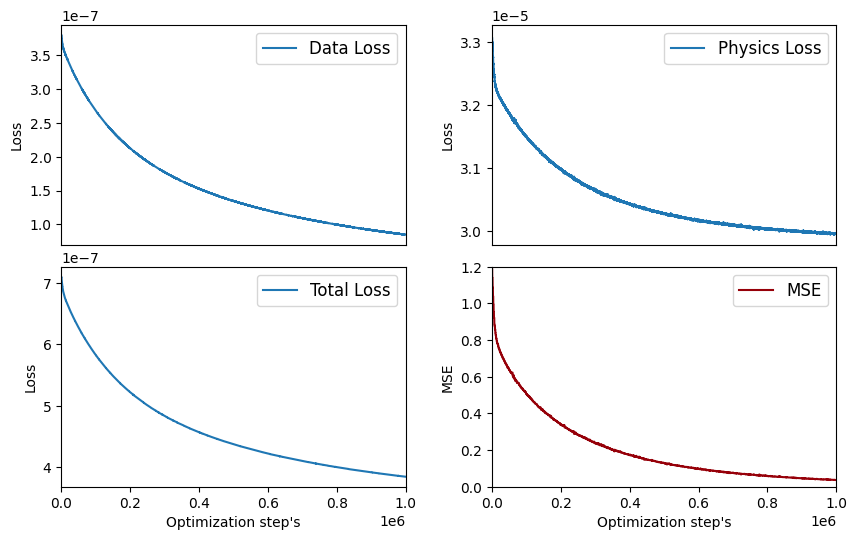

In [729]:
plt.figure(figsize=(10, 6))
plt.subplots_adjust(wspace= 0.25, hspace= 0.1)
sub1 = plt.subplot(2, 2, 1)
sub1.plot(lista_dados)
sub1.legend(["Data Loss"], fontsize='large',loc='best')
sub1.set_ylabel("Loss")
sub1.set_xticks([])
sub1.set_xlim(0,1e6)

sub2 = plt.subplot(2, 2, 2)

sub2.plot(lista_fisica)
sub2.legend(["Physics Loss"], fontsize='large',loc='best')
sub2.set_ylabel("Loss")
sub2.set_xlim(0,1e6)
sub2.set_xticks([])

sub4 = plt.subplot(2, 2, 4)
sub4.set_xlim(0,1e6)
sub4.set_ylim(0,1.2)
sub4.set_ylabel("MSE")
sub4.set_xlabel("Optimization step's")
sub4.plot(lista_MSE, color = "#960009")
sub4.legend(["MSE"], fontsize='large',loc='best')

sub5 = plt.subplot(2, 2, 3)
sub5.set_xlim(0,1e6)
sub5.set_ylabel("Loss")
sub5.set_xlabel("Optimization step's")
sub5.plot( (np.array(lista_fisica)*0.01 + np.array(lista_dados)))
sub5.legend(["Total Loss"], fontsize='large',loc='best')


plt.savefig('adaptivesystem_unforced.jpg', format='jpg', dpi=900, bbox_inches='tight')


In [718]:
array1 = test.x_test.T # Substitua isso pelo seu primeiro array
array2 = teste_o.x_test.T  # Substitua isso pelo seu segundo array

array1 - array2


array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 9.41522408e-05, -2.59210112e-05, -1.38982503e-05, ...,
        -1.69924240e-05, -1.01233962e-04,  1.41951611e-04],
       [ 1.78333979e-04, -5.59384138e-05, -5.34661927e-06, ...,
        -7.24422056e-05, -1.38180513e-04,  3.13164426e-04],
       ...,
       [-8.05160790e-02,  3.95761388e-01, -3.23833205e-01, ...,
        -6.47404039e-02,  2.31245713e-01, -1.19630234e-01],
       [-6.57188069e-02,  3.79781349e-01, -3.16272060e-01, ...,
        -6.84581528e-02,  2.18776584e-01, -8.59547888e-02],
       [-5.07407683e-02,  3.61738453e-01, -3.06850591e-01, ...,
        -7.16989950e-02,  2.05092580e-01, -5.25757533e-02]])

In [ ]:
plt. plot(resultado_x,'black')
plt.plot((theta.T@test.x_test).T[:,0],'g')
plt. plot(previsao_x,'r', linestyle = "dotted")
plt.legend(["Sistema","PI-ESN","ESN"]) 
plt.ylabel("x(t)")
plt.xlabel("Tempo(t)")
plt.savefig('x.jpg', format='jpg')


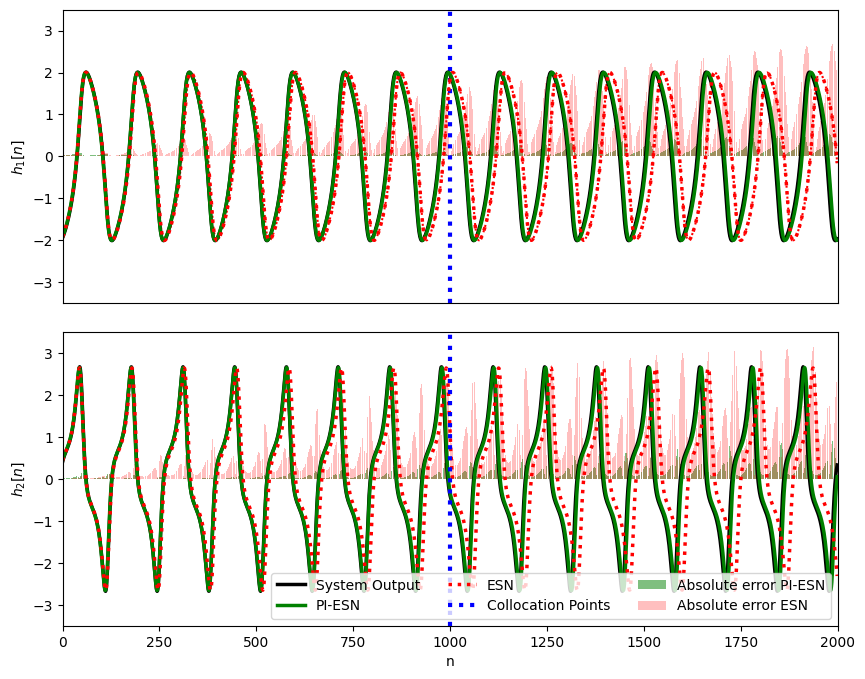

In [779]:

variables_names_list = ["h1","h2","h3","h4","h5","h6","h7","h8"]
variables_names_list = variables_names_list[:2]
    
plt.figure(figsize=(10, 8))
plt.subplots_adjust(wspace= 0.25, hspace= 0.1)
sub1 = plt.subplot(2, 1, 1)
sub1.axvline(1000, linewidth=3, color='b',linestyle = 'dotted')
sub1.set_xlim(0,2000)

plt. plot(resultado_x,'black')
plt.plot((theta.T@teste_o.x_test).T[:,0],'g')
plt. plot(previsao_x,'r', linestyle = "dotted")

erro_1 = np.abs( np.subtract(resultado_x, (theta.T@teste_o.x_test).T[:,0]) )
erro_2 = np.abs( np.subtract(resultado_x, previsao_x)) 

sub1. plot(resultado_x,'black', linewidth= linewidth_tam)
sub1.plot(((theta.T@teste_o.x_test).T[:,0]),'g', linewidth= linewidth_tam)
sub1. plot(previsao_x,'r', linestyle = "dotted", linewidth= linewidth_tam)
sub1.set_ylim(-3.5,3.5)
sub1.set_ylabel("$h_1[n]$")

sub1.set_xticks([])

sub1. bar(range(2000),erro_1, color = 'green', alpha = 0.5)
sub1. bar(range(2000),erro_2, color = 'red', alpha = 0.25)


sub2 = plt.subplot(2, 1, 2)
erro_1 = np.abs( np.subtract(resultado_y, (theta.T@teste_o.x_test).T[:,1]) )
erro_2 = np.abs( np.subtract(resultado_y, previsao_y)) 
sub2.set_xlim(0,2000)
sub2. plot(resultado_y,'black', linewidth= linewidth_tam)
sub2.plot(((theta.T@teste_o.x_test).T[:,1]),'g', linewidth= linewidth_tam)
sub2. plot(previsao_y,'r', linestyle = "dotted", linewidth= linewidth_tam)
sub2.axvline(1000, linewidth=3, color='b',linestyle = 'dotted')

sub2.set_ylim(-3.5,3.5)
sub2. bar(range(2000),erro_1, color = 'green', alpha = 0.5)
sub2. bar(range(2000),erro_2, color = 'red', alpha = 0.25)

sub2.set_xlabel("n")
sub2.set_ylabel("$h_2[n]$")

plt.legend(["System Output","PI-ESN","ESN","Collocation Points","Absolute error PI-ESN","Absolute error ESN"], ncol = 3, fontsize='medium',loc='best')
plt.savefig('unforced_h1.jpg', dpi = 600,format='jpg')
